<a href="https://colab.research.google.com/github/bhaveshUp2010/satterlite_image_segmentation/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Doing Necessary Imports

In [2]:
import os
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

###Importing processed Data from drive


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
data_path = "/content/drive/MyDrive/aerial_dataset/processed_ds/"
print(os.listdir(data_path))

['X_test.npy', 'y_test.npy', 'X_train.npy', 'y_train.npy']


In [5]:
X_train = np.load(data_path + 'X_train.npy', mmap_mode='r')
y_train = np.load(data_path +  'y_train.npy', mmap_mode='r')
X_test = np.load(data_path + 'X_test.npy', mmap_mode='r')
y_test = np.load(data_path + 'y_test.npy', mmap_mode='r')


In [6]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
image_classes = y_train.shape[3]

In [7]:
print(image_height)
print(image_width)
print(image_channels)
print(image_classes)

256
256
3
6


###Creating Custom accuracy metric

In [8]:
def Jaccard_coeff(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coeff = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coeff

In [9]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [10]:
metrics =["accuracy", Jaccard_coeff]

In [11]:
def get_dl_model():
  return multi_unet_model(n_classes=image_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [12]:
model = get_dl_model()

In [13]:
#model.get_config()

###Making Custom Loss Function

In [14]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_pred = tf.nn.sigmoid(y_pred)

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

    return 1.0 - dice

def bce_dice_loss(y_true, y_pred):
    bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    bce = tf.reduce_mean(bce)

    d_loss = dice_loss(y_true, y_pred)

    return bce + d_loss


##Model Compilation

In [15]:
tf.keras.backend.clear_session()

In [16]:
model.compile(optimizer = "adam", loss = bce_dice_loss, metrics = metrics)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_history = model.fit(X_train, y_train,
                          batch_size = 8,
                          verbose = 1,
                          epochs = 50,
                          validation_data=(X_test, y_test),
                          shuffle = False)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 66s 365ms/step - accuracy: 0.5119 - jaccard_coeff: 0.3587 - loss: 1.4154 - val_accuracy: 0.6469 - val_jaccard_coeff: 0.4878 - val_loss: 1.3812
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6942 - jaccard_coeff: 0.5374 - loss: 1.3677 - val_accuracy: 0.6553 - val_jaccard_coeff: 0.4942 - val_loss: 1.3775
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6992 - jaccard_coeff: 0.5423 - loss: 1.3656 - val_accuracy: 0.6800 - val_jaccard_coeff: 0.5196 - val_loss: 1.3716
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.7119 - jaccard_coeff: 0.5523 - loss: 1.3632 - val_accuracy: 0.6957 - val_jaccard_coeff: 0.5396 - val_loss: 1.3675
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.7132 - jaccard_coeff: 0.5580 - loss: 1.3626 - val_accuracy: 0.6790 - val_jaccard_coeff: 0.5201 - val_loss: 1.3721
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7246 - jaccard_coeff: 0.56

In [19]:
history = model_history

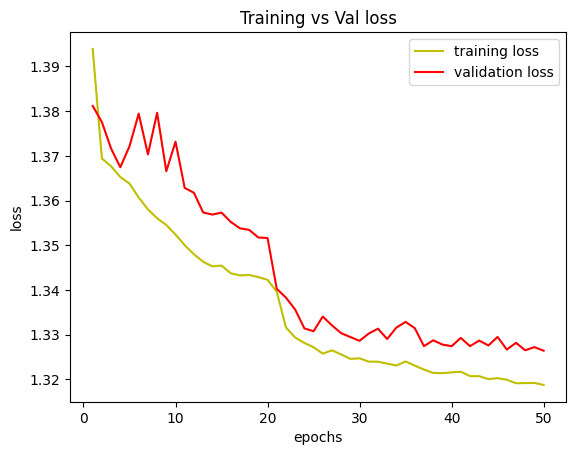

In [20]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "y", label = "training loss")
plt.plot(epochs, val_loss, "r", label = "validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training vs Val loss")
plt.legend()

plt.show()

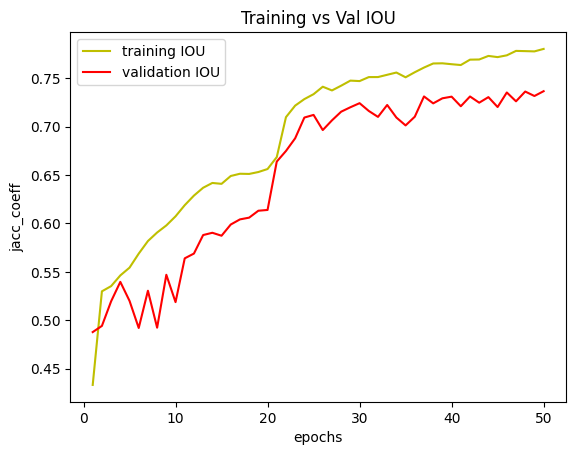

In [21]:
jaccard_coeff = history.history["jaccard_coeff"]
val_jaccard_coeff = history.history["val_jaccard_coeff"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, jaccard_coeff, "y", label = "training IOU")
plt.plot(epochs, val_jaccard_coeff, "r", label = "validation IOU")
plt.xlabel("epochs")
plt.ylabel("jacc_coeff")
plt.title("Training vs Val IOU")
plt.legend()

plt.show()

In [22]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 101}

In [23]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


In [24]:
y_pred_argmax = np.argmax(y_pred, axis= 3)
y_test_argmax = np.argmax(y_test, axis = 3)

##Comparing prediction resuult

In [25]:
test_img_num = random.randint(0, len(X_test))

test_img = X_test[test_img_num]
ground_truth = y_test_argmax[test_img_num]

test_img_input = np.expand_dims(test_img, 0)

pred_img = model.predict(test_img_input)
pred_img = np.argmax(pred_img, axis= 3 )[0, :, :]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [26]:
pred_img

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 2],
       [1, 1, 1, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3]])

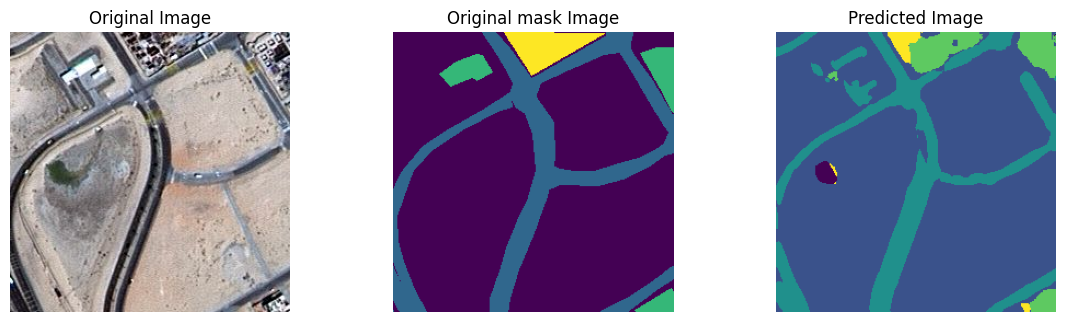

In [27]:
plt.figure(figsize=(14, 8))

plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_img)
plt.axis("off")

plt.subplot(232)
plt.title("Original mask Image")
plt.imshow(ground_truth)
plt.axis("off")

plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(pred_img)
plt.axis("off")

plt.show()

In [29]:
model.save("satterlite_img_seg_unet.keras")

In [30]:
!ls -lah

total 45M
drwxr-xr-x 1 root root 4.0K Nov 19 04:42 .
drwxr-xr-x 1 root root 4.0K Nov 19 04:27 ..
drwxr-xr-x 4 root root 4.0K Nov 17 14:29 .config
drwx------ 5 root root 4.0K Nov 19 04:30 drive
drwxr-xr-x 1 root root 4.0K Nov 17 14:29 sample_data
-rw-r--r-- 1 root root  23M Nov 19 04:40 satterlite_img_seg_unet.h5
-rw-r--r-- 1 root root  23M Nov 19 04:42 satterlite_img_seg_unet.keras
